[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/05_td.ipynb)

# *Temporal Difference* 

En el post anterior vimos cómo los métodos de Monte Carlo nos permiten entrenar agentes sin necesidad de conocer el modelo del entorno. Sin embargo, estos métodos tienen ciertas limitaciones, principalmente la necesidad de esperar a que un episodio termine para poder actualizar la función de valor y política. Esto puede llegar a ser muy costoso computacionalmente hablando en entornos con muchos estados y acciones, y directamente imposible en entornos continuos en los que no se puede determinar cuándo un episodio termina. Para solventar este problema, existen los métodos de *temporal difference learning* (TD), que básicamente permiten actualizar la función de valor y política de forma incremental (lo que también se conoce como *bootstrapping*), sin necesidad de esperar a que un episodio termine. Esto los hace mucho más eficientes computacionalmente hablando, y por lo tanto, más adecuados para entornos continuos.

Los métodos TD combinan ideas de MC y DP. Cómo MC son *model-free*, no necesitan conocer el modelo del entorno, y como DP actualizan la función de valor y política basándose en la información estimada disponible, sin necesidad de esperar a que un episodio termine para poder hacerlo. Es el siguiente post veremos como es posible unificar estas ideas en un solo algoritmo.

## Predicción

De nuevo, nuestro objetivo es estimar el valor $v_{\pi}(s)$ de un estado $s$ bajo una política $\pi$ a partir de la experiencia de nuestro agente. A diferencia de MC, en TD no necesitamos esperar a que un episodio termine para poder actualizar la función de valor. En TD, la función de valor se actualiza de forma incremental, basándose en la información disponible en cada paso del episodio. El método *TD* más simple puede expresarse de la siguiente forma:

$$
	V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right]
$$

donde $S_t$ es el estado en el paso $t$, $R_{t+1}$ es la recompensa recibida al pasar al estado $S_{t+1}$, y $\alpha$ es el *learning rate* (ratio de aprendizaje). Este método se conoce como *TD(0)*, ya que solo considera la recompensa recibida en el siguiente paso.

Vamos a ver un ejemplo de aplicación en nuestro problema simple en el que un agente debe recorrer el tablero desde el punto a al punto B.

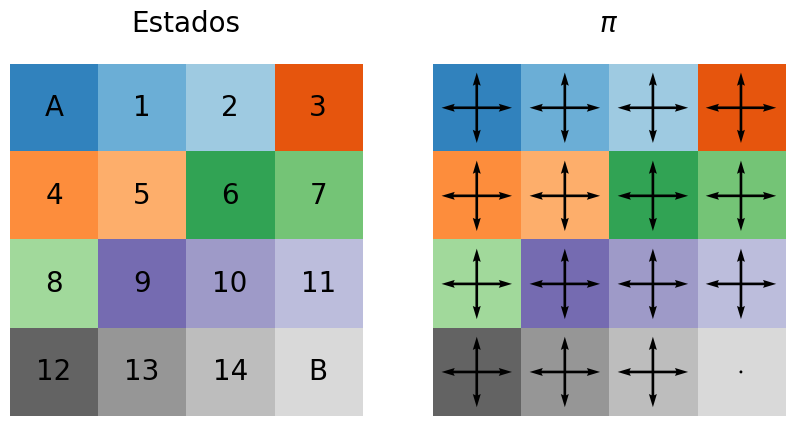

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_env(v, a=None, title="$v_k$"):
    v = v.reshape(4,4)
    if a is None:
        R, T = np.ones((4,4)), np.ones((4,4))
        L, B = -1.*R, -1.*T
    else:
        T = a[:,0].reshape((4,4))
        B = -1*a[:,1].reshape((4,4))
        R = a[:,2].reshape((4,4))
        L = -1*a[:,3].reshape((4,4))
    R[3,3] = 0
    T[3,3] = 0
    B[3,3] = 0
    L[3,3] = 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    zeros = np.zeros((4,4))
    ax1.matshow(v, cmap=plt.cm.tab20c)
    ax2.matshow(v, cmap=plt.cm.tab20c)
    for i in range(4):
        for j in range(4):
            c = v[j,i]
            if (i==0 and j==0):
                ax1.text(i, j, 'A', va='center', ha='center', fontsize=20, color="black")
            elif (i==3 and j==3):
                ax1.text(i, j, 'B', va='center', ha='center', fontsize=20, color="black")
            else:
                ax1.text(i, j, f'{round(c,1)}', va='center', ha='center', fontsize=20, color="black")
    ax2.quiver(L, zeros, scale=10)
    ax2.quiver(R, zeros, scale=10)
    ax2.quiver(zeros, T, scale=10)
    ax2.quiver(zeros, B, scale=10)
    ax1.axis(False)
    ax1.set_title(title, fontsize=20)
    ax2.axis(False)
    ax2.set_title("$\pi$", fontsize=20)
    plt.show()
    
estados = np.arange(16)
plot_env(estados, title="Estados")

In [2]:
from tqdm import tqdm

def eval_pol(pi, alpha=1, gamma=1, num_eps=100, seed=608, verbose=False):
    seed = np.random.randint(1000) if seed is None else seed
    # print(seed)    
    np.random.seed(seed)
    # inicializamos función de valor
    v = np.zeros(16)
    # generar episodio siguiendo la política
    for e in tqdm(range(num_eps)):
        s = 0 # estado inicial
        while s != 15:
            a = np.random.choice(4, p=pi[s]) # acción según política
            s_next = s + [-4 if s >= 4 else 0, 4 if s < 12 else 0, 1 if (s+1) % 4 else 0, -1 if s % 4 else 0][a] # top, bot, right, left
            r = -1 # recompensa
            if verbose: print(s, a, s_next, r)
            td_target = r + gamma*v[s_next] # target
            td_error = td_target - v[s] # error
            v[s] += alpha*td_error
            s = s_next
    return v

100%|██████████| 1/1 [00:00<00:00, 1221.76it/s]

0 2 1 -1
1 1 5 -1
5 1 9 -1
9 2 10 -1
10 2 11 -1
11 1 15 -1


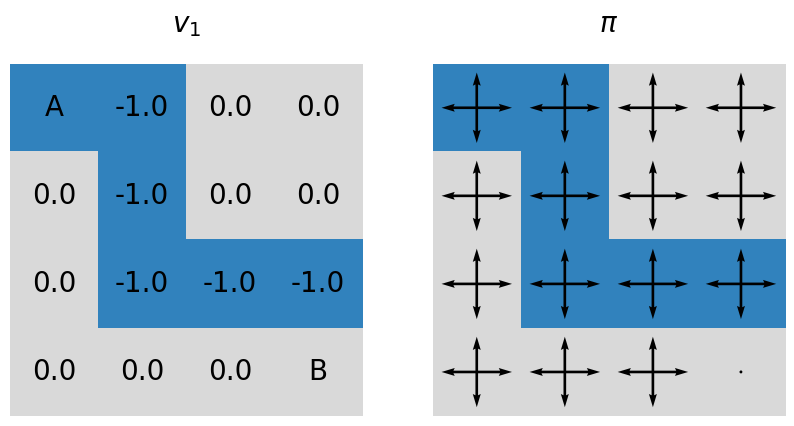

In [3]:
# política inicial (random)
pi = 0.25*np.ones((16, 4))

v = eval_pol(pi, num_eps=1, verbose=True)
plot_env(v, title="$v_{1}$")

De nuevo, al igual con MC, en un solo episodio nuestro agente solo actualiza los valores de la función de valor de aquello estados que ha visitado. Para tener estimaciones del resto, deberá explorar nuevos caminos en nuevos episodios. Sin embargo, a diferencia de MC en que en el primer eposodio cada estado tenía un valor igual al número de pasos necesarios para encontrar la salida (con el signo cambiado), ahora todos los estados visitados tienen el mismo valor. Esto ilustra muy bien la idea de que TD es un método *bootstrapping*, ya que en cada paso del episodio actualiza la función de valor basándose en la información disponible en ese momento, sin necesidad de esperar a que el episodio termine, mientras que MC actualiza la función de valor basándose en la información disponible en el episodio completo y por lo tanto es capaz de asignar el valor correcto a todos los estados visitados.

$$
v_{\pi}(s) = E_{\pi}[G_t|S_t=s] 
$$

$$
v_{\pi}(s) = E_{\pi}[R_{t+1} + \gamma v_{\pi}(S_{t+1})|S_t=s] 
$$

100%|██████████| 2/2 [00:00<00:00, 1863.31it/s]


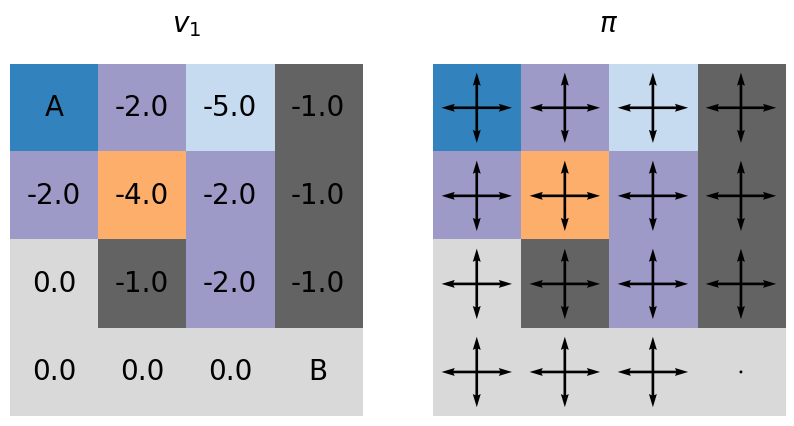

In [4]:
v = eval_pol(pi, num_eps=2, verbose=False)
plot_env(v, title="$v_{1}$")

100%|██████████| 10000/10000 [00:10<00:00, 975.85it/s]


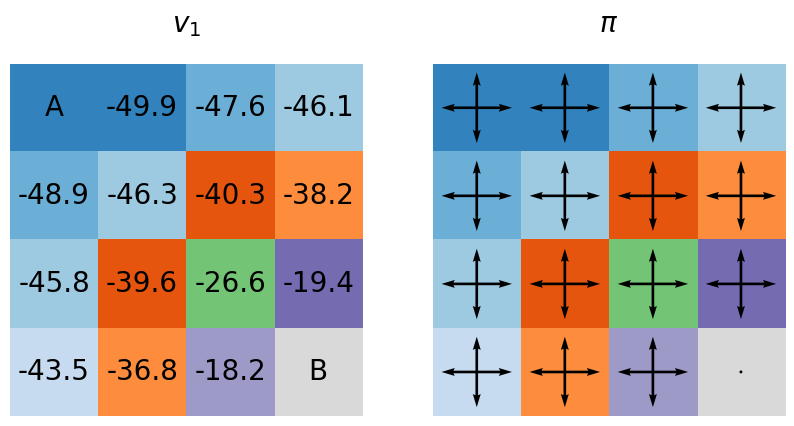

In [5]:
v = eval_pol(pi, num_eps=10000, alpha=0.1, verbose=False)
plot_env(v, title="$v_{1}$")

## SARSA: *On-Policy TD Control*

Vamos ahora a centrarnos en el problema del control (optimización de la política) usando *TD*. Como siempre, usamos el algoritmo de *policy iteration*. Para ello, el primer paso es aprender una función de valor para los estados-acciones.

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right]
$$

Usaremos el ejemplo del *windy world*

In [6]:
def plot_env_windy(v, w=10, h=7, start=(3, 0), end=(3, 7), a=None, title="$v_k$", scale=10):
    shape = (h, w)
    v = v.reshape(shape)
    if a is None:
        R, T = np.ones(shape), np.ones(shape)
        L, B = -1.*R, -1.*T
    else:
        T = a[:,0].reshape(shape)
        B = -1*a[:,1].reshape(shape)
        R = a[:,2].reshape(shape)
        L = -1*a[:,3].reshape(shape)
    R[end] = T[end] = B[end] = L[end] = 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
    ax1.matshow(v, cmap=plt.cm.tab20c)
    ax2.matshow(v, cmap=plt.cm.tab20c)
    for i in range(w):
        for j in range(h):
            c = v[j,i]
            if (j, i) == start:
                ax1.text(i, j, 'A', va='center', ha='center', fontsize=10, color="black")
            elif (j, i) == end:
                ax1.text(i, j, 'B', va='center', ha='center', fontsize=10, color="black")
            else:
                ax1.text(i, j, f'{round(c,1)}', va='center', ha='center', fontsize=10, color="black")
    zeros = np.zeros(shape)
    ax2.quiver(L, zeros, scale=scale)
    ax2.quiver(R, zeros, scale=scale)
    ax2.quiver(zeros, T, scale=scale)
    ax2.quiver(zeros, B, scale=scale)
    ax1.axis(False)
    ax1.set_title(title, fontsize=20)
    ax2.axis(False)
    ax2.set_title("$\pi$", fontsize=20)
    plt.show()

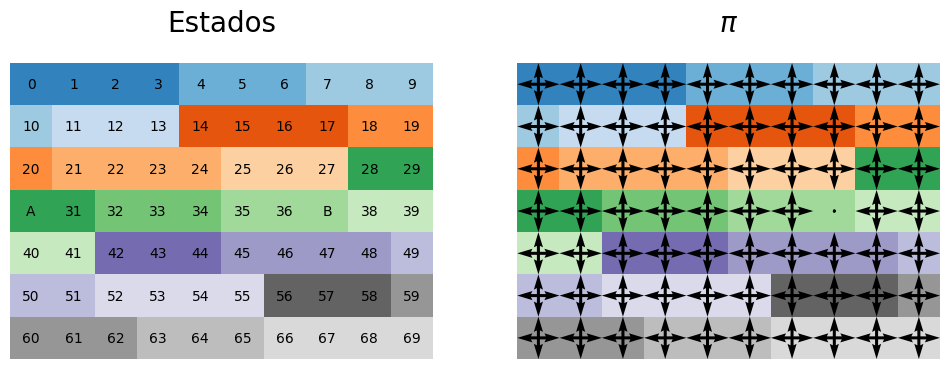

In [7]:
w, h = 10, 7
estados = np.arange(w*h)
plot_env_windy(estados, w, h, title="Estados", scale=20)

In [8]:
def e_greedy(pi, s, epsilon):
    if np.random.rand() < 1 - epsilon: # e-greedy
        return np.random.choice(4, p=pi[s]) # acción según política
    return np.random.choice(4) # acción aleatoria

def apply_wind(s, w, wind):
    # get the column
    col, row = s % w, s // w
    if row == 0: return 0
    # find column in wind dict
    return min(wind[col], row)

def eval_q(pi, w, h, start_state, end_state, wind, alpha=1, gamma=0.9, num_eps=100, seed=608, epsilon=0, verbose=False, pbar=True):
    seed = np.random.randint(1000) if seed is None else seed
    # print(seed)    
    np.random.seed(seed)
    # inicializamos función de valor
    q = np.random.random((h*w, 4))
    q[end_state] = 0
    # generar episodio siguiendo la política
    if pbar: p = tqdm(range(num_eps))
    else: p = range(num_eps)
    for e in p:
        s = start_state # estado inicial
        a = e_greedy(pi, s, epsilon) # acción inicial según política
        while s != end_state:
            s_next = s + [-w if s >= w else 0, w if s < w*(h-1) else 0, 1 if (s+1) % w else 0, -1 if s % w else 0][a] 
            s_next = s_next - w*apply_wind(s_next, w, wind)
            r = -1 # recompensa
            a_next = e_greedy(pi, s_next, epsilon) # acción según política
            if verbose: print(s, a, r, s_next, a_next) # SARSA
            td_target = r + gamma*q[s_next][a_next] # target  
            td_error = td_target - q[s][a] # error
            q[s][a] += alpha*td_error
            s, a = s_next, a_next
    return q

def eval_pol(pi, w, h, start_state, end_state, wind, alpha=1, gamma=0.9, num_eps=100, seed=608, verbose=False, max_its=1000):
    seed = np.random.randint(1000) if seed is None else seed
    # print(seed)    
    np.random.seed(seed)
    # inicializamos función de valor
    v = np.zeros(h*w)
    # generar episodio siguiendo la política
    for e in tqdm(range(num_eps)):
        s = start_state # estado inicial
        its = 0
        while s != end_state and its <= max_its:
            a = np.random.choice(4, p=pi[s]) # acción según política
            s_next = s + [-w if s >= w else 0, w if s < w*(h-1) else 0, 1 if (s+1) % w else 0, -1 if s % w else 0][a] 
            s_next = s_next - w*apply_wind(s_next, w, wind)            
            r = -1 # recompensa
            if verbose: print(s, a, s_next, r)
            td_target = r + gamma*v[s_next] # target
            td_error = td_target - v[s] # error
            v[s] += alpha*td_error
            s = s_next
            its += 1
    return v

def greedy_pol_windy(q, w, h):
    p = np.zeros((w*h,4))
    # set nans to -inf
    q[np.isnan(q)] = -np.inf
    p[range(w*h), q.argmax(axis=1)] = 1 
    return p

100%|██████████| 50/50 [00:00<00:00, 56.09it/s]


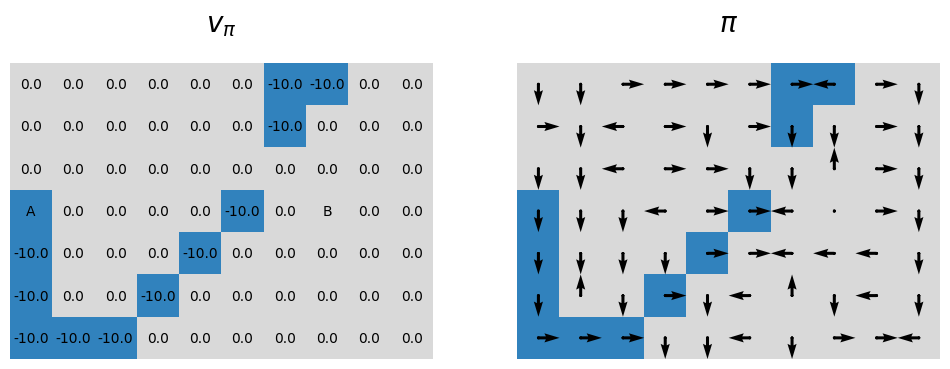

In [9]:
h, w, start, end = 7, 10, 30, 37
wind = [0,0,0,1,1,1,2,2,1,0] # value applied at each column

pi = 0.25*np.ones((h*w, 4))
q = eval_q(pi, w, h, start, end, wind, alpha=0.5, num_eps=10) # no va... bug?
pi = greedy_pol_windy(q, w, h)
v = eval_pol(pi, w, h, start, end, wind, alpha=0.5, num_eps=50) # siempre haremos las mismas acciones
plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

In [10]:
def value_iteration(w, h, start, end, wind, epsilon=0.1, max_its=100):
    pi = 0.25*np.ones((h*w, 4))
    for it in tqdm(range(max_its)):
        q = eval_q(pi, w, h, start, end, wind, epsilon=epsilon, alpha=0.5, num_eps=1, pbar=False) # mejoramos politica con 1 episodio
        pi = greedy_pol_windy(q, w, h)
    v = eval_pol(pi, w, h, start, end, wind, alpha=0.5, num_eps=50) 
    return v, pi

In [11]:
# v, pi, lens, eps = value_iteration(w, h, start, end, wind, max_its=10)
# plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

## Q-learning: *Off-Policy TD Control*

*Off-policy learning* hace referencia al hecho de aproximar las funciones de valor usando una política determinada $\pi(a|s)$ mientras que nuestro agente sigue una política diferente $\mu(a|s)$. Esto es interesante ya que habilita a un agente a aprender observando comportamiento humano u otros agentes, re-utilizar experiencia de políticas pasadas, aprender una política óptima mientras se sigue una política exploratoria e incluso aprender múltiples políticas a la vez mientras se sigue una única política.

En el caso de *TD(0)* podemos derivar el algoritmo conocido como *Q-learning* de la siguiente forma: 

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A') - Q(S_t, A_t) \right]
$$

donde $A'$ es la acción que escogería la segunda política en el estado $S_{t+1}$.

Si elegimos que la segunda política actúa de manera *greedy* con respecto a la primera, entonces el algoritmo se reduce a:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a) - Q(S_t, A_t) \right]
$$

In [16]:
def eval_q(pi, w, h, start_state, end_state, wind, alpha=1, gamma=0.9, num_eps=100, seed=608, epsilon=0, verbose=False, pbar=True):
    seed = np.random.randint(1000) if seed is None else seed
    # print(seed)    
    np.random.seed(seed)
    # inicializamos función de valor
    q = np.random.random((h*w, 4))
    q[end_state] = 0
    # generar episodio siguiendo la política
    if pbar: p = tqdm(range(num_eps))
    else: p = range(num_eps)
    for e in p:
        s = start_state # estado inicial
        while s != end_state:
            a = e_greedy(pi, s, epsilon) 
            s_next = s + [-w if s >= w else 0, w if s < w*(h-1) else 0, 1 if (s+1) % w else 0, -1 if s % w else 0][a] 
            s_next = s_next - w*apply_wind(s_next, w, wind)
            r = -1 # recompensa
            if verbose: print(s, a, r, s_next) 
            td_target = r + gamma*q[s_next].max() # target
            td_error = td_target - q[s][a] # error
            q[s][a] += alpha*td_error
            s = s_next
    return q

100%|██████████| 50/50 [00:00<00:00, 3147.55it/s]


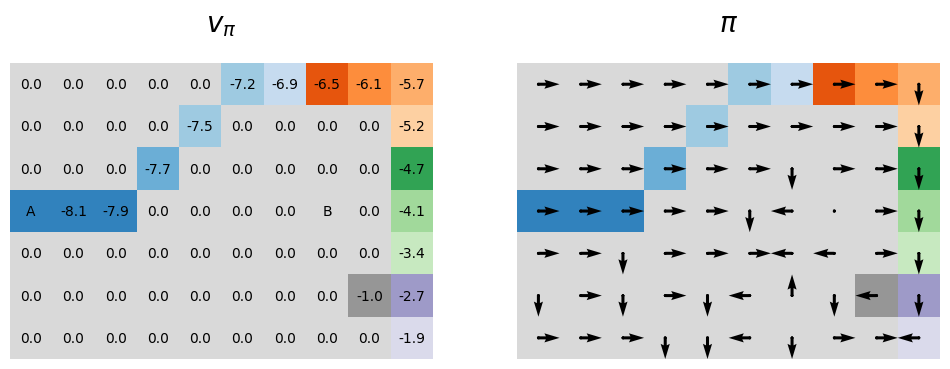

In [13]:
pi = 0.25*np.ones((h*w, 4))
q = eval_q(pi, w, h, start, end, wind, alpha=0.5, num_eps=50) # esto si funciona
pi = greedy_pol_windy(q, w, h)
v = eval_pol(pi, w, h, start, end, wind, alpha=0.5, num_eps=50) # siempre haremos las mismas acciones
plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

In [18]:
# v, pi, lens, eps = value_iteration(w, h, start, end, wind, max_its=10)
# plot_env_windy(v, a=pi, title="$v_\pi$", scale=20)

## Resumen